# Signal Processing

Signal processing focuses on analysing, modifying, and synthesizing signals such as triaxial sensor signals we'll be working with. In our case, signal processing techniques are primarily used to emphasize and detect components of interest in the sensor signals. Signal processing also allows us to remove e.g. high frequency noise from the data which might not be relevant for the problem we aim to solve.

## Data Loading

Import the required libraries to perform the signal processing.

In [9]:
import sys
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(1, '../src/')
from glob import glob
from utils import load_raw_data, visualize_triaxial_signals, load_signal
from scipy.signal import medfilt
from scipy.fftpack import fft, fftfreq, ifft 

Load the data using the functions defined earlier.

In [3]:
acc_df, gyro_df, label_df = load_raw_data()

## Signal processing

We'll explore three types of signal processing functions that have been used to create the HAR dataset. We'll apply these filters onto a toy signal first, and then on the actual HAR data.

The following filters have been applied to the time signals:
- A median filter with a kernel size of 3.
- A 3rd order low pass Butterworth filter with a corner frequency of 20 Hz to remove noise. 
- Signal separation into DC, body & noise signals using FFT and iFFT transforms.

### Median filter

In the median filter, a sliding window is applied to the data and each data point is replaced by the median of the values in the corresponding window.
Median filtering is a non-linear digital filtering technique, often used to remove noise from a signal. Such noise reduction is a typical pre-processing step to improve the results of later processing.

In [5]:
def med_filter(data, kernel_size=3):
    return medfilt(data, kernel_size=kernel_size)

We'll first apply the median filter to a toy signal.

Text(0.5, 1.0, '10 Hz and 20 Hz sinusoids with median filter')

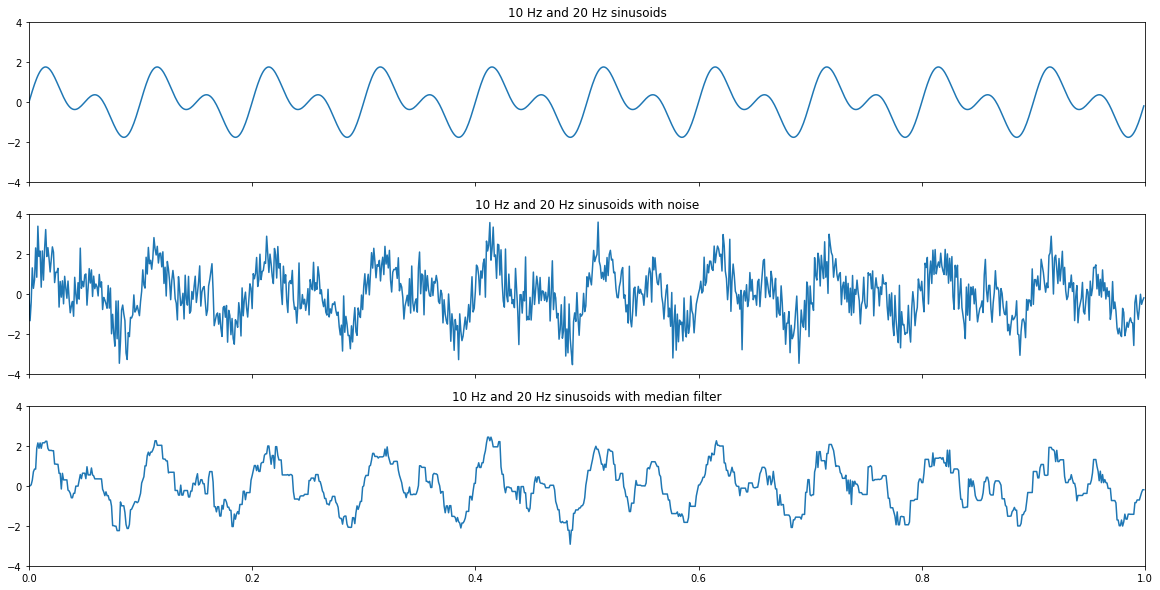

In [27]:
t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20, 10))

ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -4, 4])

sig += np.random.normal(scale=0.75, size=1000)
ax2.plot(t, sig)
ax2.set_title('10 Hz and 20 Hz sinusoids with noise')
ax2.axis([0, 1, -4, 4])

ax3.plot(t, med_filter(sig,kernel_size=5))
ax3.axis([0, 1, -4, 4])
ax3.set_title('10 Hz and 20 Hz sinusoids with median filter')

As you can see, the filter removes most of the noise, but also destroys some of the actual signal. This is a trade-off that always needs to be taken into account when doing signal processing. 

Let's apply the median filter to the sensor data. First, we'll plot without the filter, then with the filter.

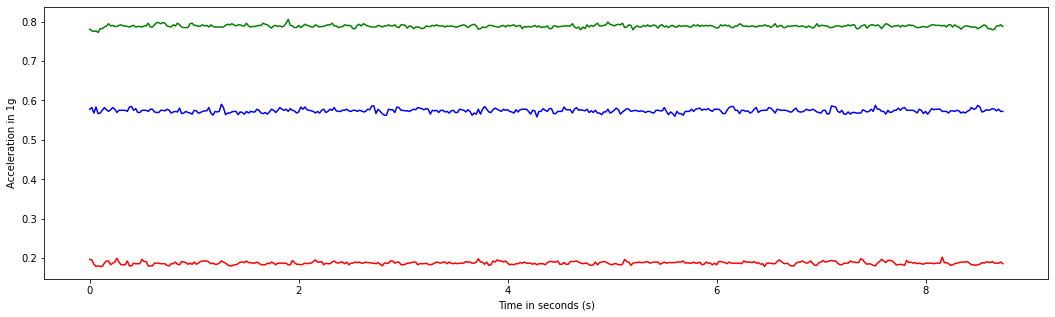

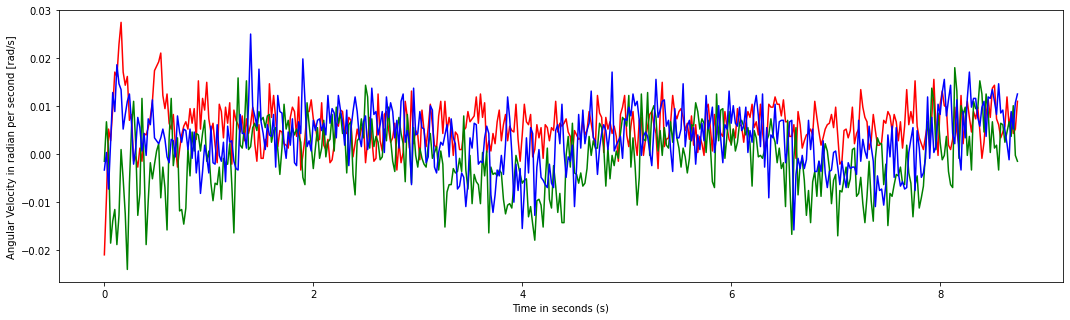

In [31]:
acc, gyro = load_signal(label_df, acc_df, gyro_df, user_number_ID=1, activity_number_ID=6, experiment_number_ID=1)
acc, gyro = acc.head(len(acc)//2), gyro.head(len(gyro)//2)
visualize_triaxial_signals(acc, gyro)

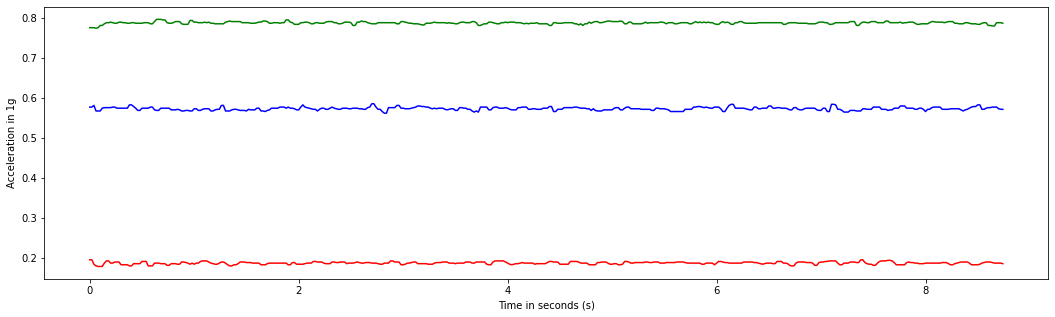

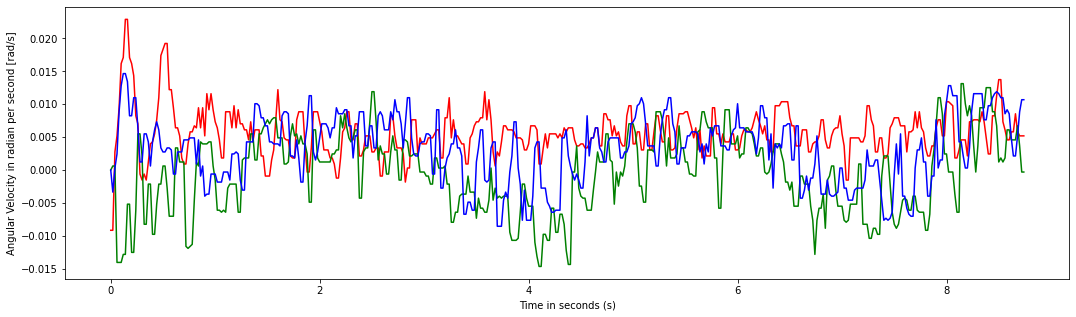

In [32]:
for coord in ('X', 'Y', 'Z'):
    acc[f"acc_{coord}"] = med_filter(acc[f"acc_{coord}"])
    gyro[f"gyro_{coord}"] = med_filter(gyro[f"gyro_{coord}"])
visualize_triaxial_signals(acc, gyro)

### Butter filter

The Butter(worth) filter is a type of filter designed to have a frequency response as flat as possible in the passband. The type of butter filter we'll be using is a low pass filter with a cut-off frequency of 20Hz, meaning that all frequencies above this frequency will be filtered out. This type of Butter filter is generally used when high frequencies are expected to introduce noise.

In [33]:
def butter_filter(data, order=3, fc=20, sampling_freq=50):
    w = fc / (sampling_freq / 2) 
    b, a = sp.signal.butter(order, w, 'low')
    return sp.signal.filtfilt(b, a, data)

We'll first apply the butter filter to a toy signal.

Text(0.5, 1.0, '10 Hz and 20 Hz sinusoids with butter filter at 15 Hz cut-off')

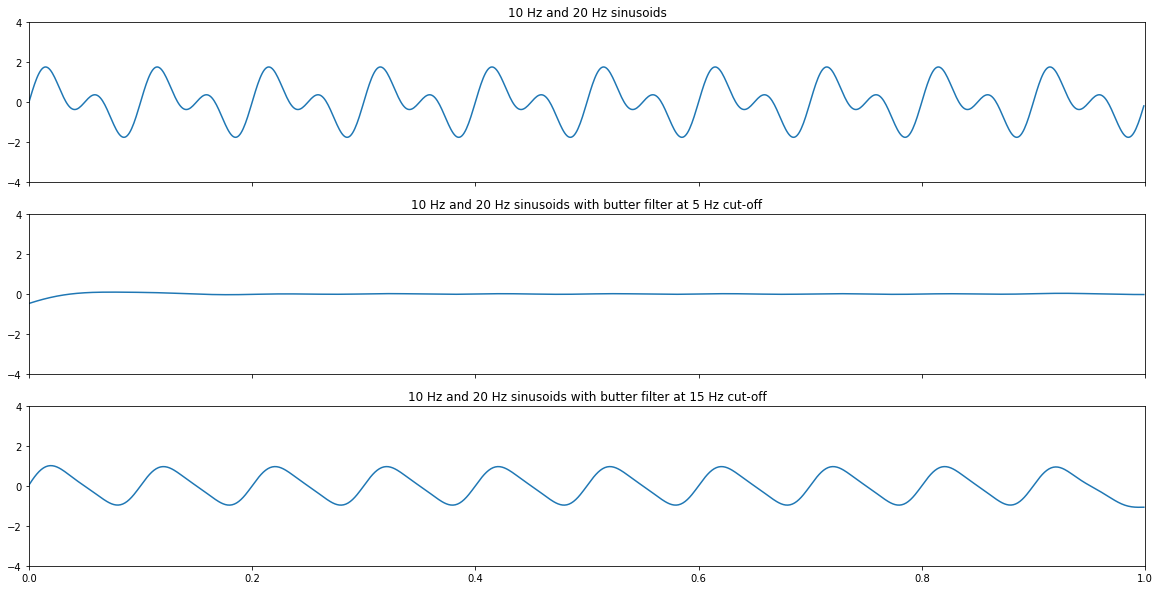

In [48]:
t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20, 10))

ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -4, 4])

ax2.plot(t, butter_filter(sig, fc=5, sampling_freq=1000))
ax2.axis([0, 1, -4, 4])
ax2.set_title('10 Hz and 20 Hz sinusoids with butter filter at 5 Hz cut-off')

ax3.plot(t, butter_filter(sig, fc=15, sampling_freq=1000))
ax3.axis([0, 1, -4, 4])
ax3.set_title('10 Hz and 20 Hz sinusoids with butter filter at 15 Hz cut-off')

As you can see, the filter removes all of the signal if we set cut-off frequency at 5 Hz and it removes one of the frequencies if we set the cut-off frequency at 15Hz.
Let's apply the butter filter to the sensor data. First, we'll plot without the filter, then with the filter.

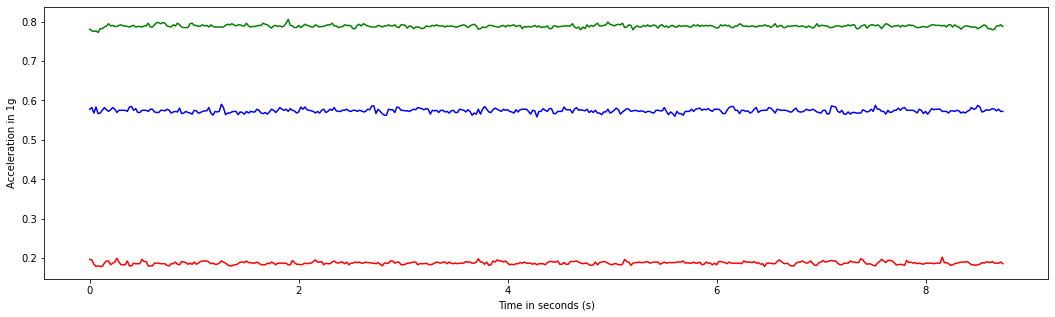

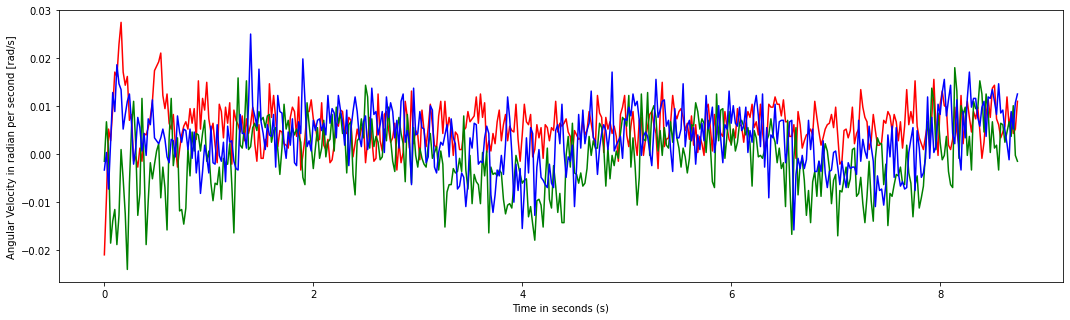

In [51]:
acc, gyro = load_signal(label_df, acc_df, gyro_df, user_number_ID=1, activity_number_ID=6, experiment_number_ID=1)
acc, gyro = acc.head(len(acc)//2), gyro.head(len(gyro)//2)
visualize_triaxial_signals(acc, gyro)

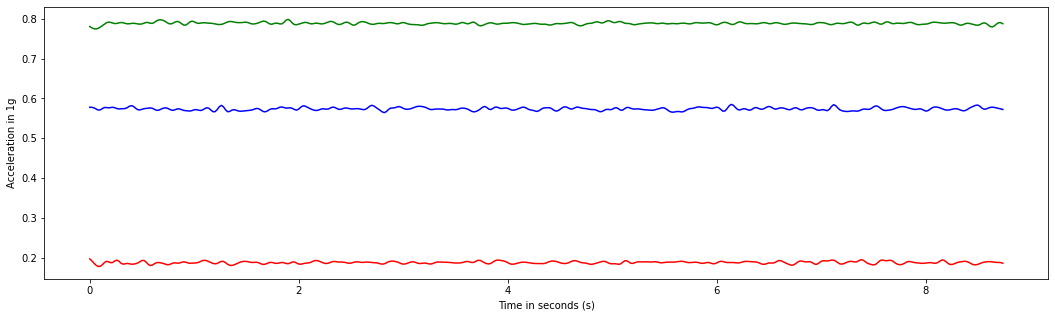

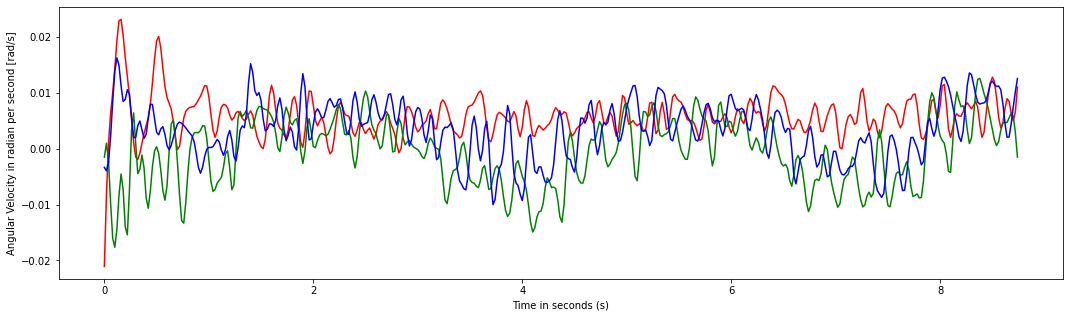

In [52]:
for coord in ('X', 'Y', 'Z'):
    acc[f"acc_{coord}"] = butter_filter(acc[f"acc_{coord}"], fc=10)
    gyro[f"gyro_{coord}"] = butter_filter(gyro[f"gyro_{coord}"], fc=10)
visualize_triaxial_signals(acc, gyro)

### Component selection

In component selection, we are not removing certain frequencies, rather, we are splitting the signal into different components based on their frequency. Specifically, the rotation and acceleration are influenced by gravitional forces.
As we are trying to predict the activity, we are less interested in signal coming from gravitational forces as these forces are present all the time. 

In the next section, we'll remove the gravitional component from the sensor data.

In [54]:
def component_selection(t_signal, freq1=0.3, freq2=20, sampling_freq=50):
    # freq1 is the cuttoff frequency between the DC components [0, freq1] and the body components [freq1, freq2]
    # freq2 is the cuttoff frequency between the body components [freq1, freq2] and the high frequency noise components [freq2,nyq] 
    nyq = sampling_freq/2
    t_signal = np.array(t_signal)
    # generate frequencies associated to f_signal complex values
    t_signal_length = len(t_signal)
    freqs = np.array(sp.fftpack.fftfreq(t_signal_length, d=1/float(sampling_freq))) 
    f_signal_length = len(freqs)
    
    # the t_signal in frequency domain after applying fft
    f_signal=fft(t_signal)
    f_DC_signal, f_body_signal, f_noise_signal=[], [], []
    for i in range(f_signal_length):
        freq = freqs[i]
        value = f_signal[i]
        
        if abs(freq)<freq1:
            f_DC_signal.append(value) 
            f_noise_signal.append(0)
            f_body_signal.append(0)
        elif (abs(freq)>=freq2):
            f_DC_signal.append(0) 
            f_noise_signal.append(value)
            f_body_signal.append(0)
        elif (abs(freq)>=0.3 and abs(freq)<20):
            f_DC_signal.append(0) 
            f_noise_signal.append(0)
            f_body_signal.append(value)
    
    t_DC_component= ifft(np.array(f_DC_signal)).real
    t_body_component= ifft(np.array(f_body_signal)).real
    t_noise=ifft(np.array(f_noise_signal)).real
    t_denoised=t_signal-t_noise 
    
    return (t_denoised,t_DC_component,t_body_component,t_noise)

We split the signals into the body and DC/gravitional component.

In [55]:
acc_DC, acc_body = pd.DataFrame(), pd.DataFrame()
gyro_DC, gyro_body = pd.DataFrame(), pd.DataFrame()
for coord in ('X', 'Y', 'Z'):
    acc[f"acc_{coord}"], acc_DC[f"acc_{coord}"],acc_body[f"acc_{coord}"], _ = component_selection(acc[f"acc_{coord}"], freq1=0.3, freq2=20)
    gyro[f"gyro_{coord}"], gyro_DC[f"gyro_{coord}"],gyro_body[f"gyro_{coord}"], _ = component_selection(gyro[f"gyro_{coord}"], freq1=0.3, freq2=20)

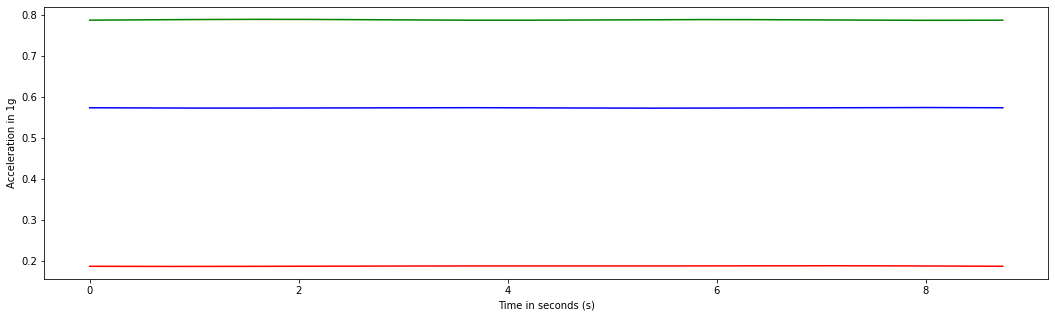

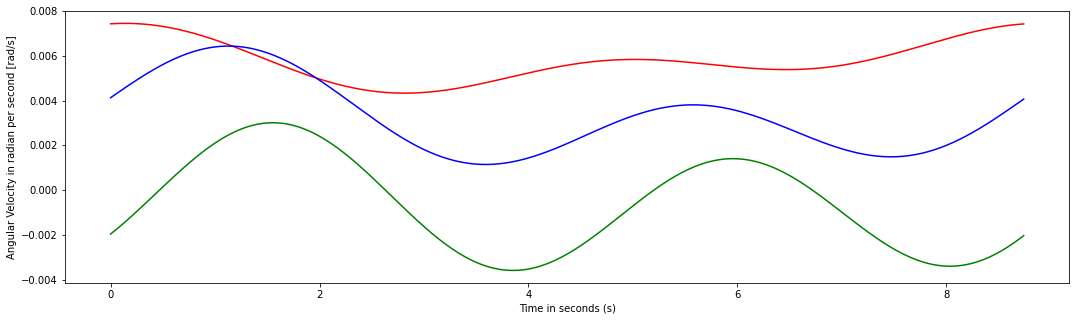

In [56]:
visualize_triaxial_signals(acc_DC, gyro_DC)

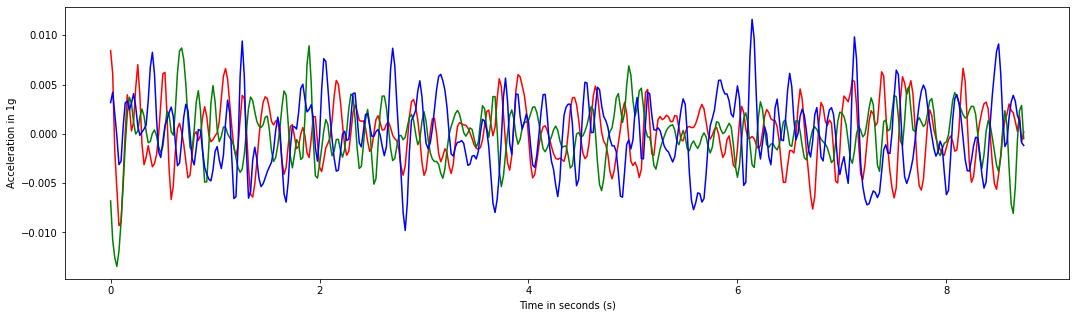

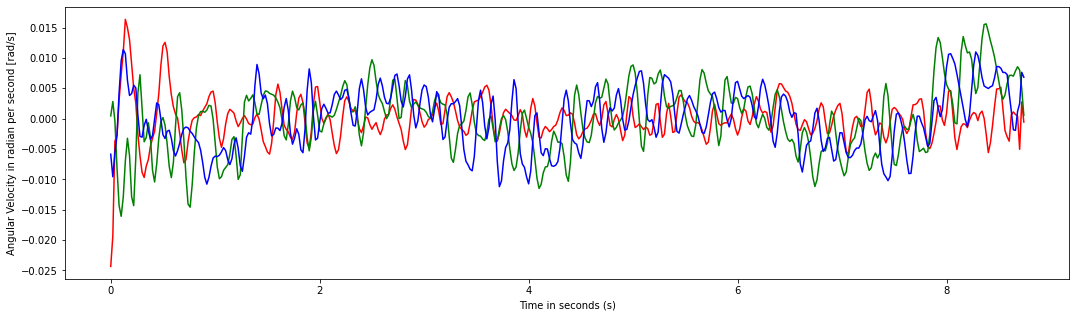

In [57]:
visualize_triaxial_signals(acc_body, gyro_body)

As you can observe, we've removed the base gravitional signal in both sensor signals.

## Conclusion

In the Signal Processing phase,we have explored three types of signal processing functions that have been used to create the HAR dataset. We've applied these filters both to toy signals as well as on the actual HAR data.

In the next section, we'll assume the data has been pre-processed through these signal processing functions, and we'll investigate the range of feature we can extract from the data.